In [13]:
import pandas as pd
from os import getcwd, listdir
from os.path import join
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

## 1. Load NHANES 2013-2014 Physical Activity Monitor Data

The file "paxmin_h.xpt" can be downloaded from the NHANES website: https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/PAXMIN_H.XPT

In [3]:
paxmin = pd.read_sas(join(getcwd(), "data", "xpt", "Examination", "paxmin_h.xpt"))

In [4]:
paxmin.head()

,SEQN,PAXDAYM,PAXDAYWM,PAXSSNMP,PAXTSM,PAXAISMM,PAXMTSM,PAXMXM,PAXMYM,PAXMZM,PAXPREDM,PAXTRANM,PAXLXSM,PAXLXSDM,PAXQFM,PAXFLGSM
0,73557.0,b'1',b'3',5.397605e-79,60.0,5.397605e-79,17.112,6.785,3.513,6.814,b'1',b'0',1755.17,884.07,5.397605e-79,b''
1,73557.0,b'1',b'3',4.800000e+03,60.0,5.397605e-79,14.366,5.222,4.117,5.027,b'1',b'0',2267.79,441.48,5.397605e-79,b''
2,73557.0,b'1',b'3',9.600000e+03,60.0,5.397605e-79,5.856,1.588,2.160,2.108,b'1',b'0',2464.71,253.51,5.397605e-79,b''
3,73557.0,b'1',b'3',1.440000e+04,60.0,5.397605e-79,13.570,4.482,3.529,5.558,b'1',b'0',2419.58,189.84,5.397605e-79,b''
4,73557.0,b'1',b'3',1.920000e+04,60.0,5.397605e-79,10.862,3.619,2.429,4.814,b'1',b'0',1877.48,572.88,5.397605e-79,b''


Please visit https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/PAXMIN_H.htm for more information about the dataset.

- SEQN - Respondent sequence number
- PAXDAYM - Day of PAM measurements for this minute
- PAXDAYWM - Day of the week for this minute
- PAXSSNMP - Starting sample number for minute
- PAXTSM - Total seconds with data for this minute
- PAXAISMM - Minute count: 80hz data idle sleep mode
- PAXMTSM - MIMS triaxial value for the minute
- PAXMXM - MIMS X-axis value for the minute
- PAXMYM - MIMS Y-axis value for the minute
- PAXMZM - MIMS Z-axis value for the minute
- PAXPREDM - Minute wake/sleep/non-wear prediction
- PAXTRANM - Transition flag for wake/sleep/non-wear
- PAXLXMM - Mean lux value for the minute
- PAXLXSDM - Std deviation: lux values in this minute
- PAXQFM - Minute sum: data quality flag count
- PAXFLGSM - Quality flags triggered

## 2. Data Preprocessing

In [5]:
paxmin = paxmin.loc[:, ['SEQN', 'PAXDAYM', 'PAXDAYWM', 'PAXMTSM']] # Drop all other columns

Solving read_sas bug: https://github.com/pandas-dev/pandas/issues/30051

In [6]:
paxmin = paxmin.replace(5.397605346934028e-79,0) 

In [7]:
paxmin.head()

,SEQN,PAXDAYM,PAXDAYWM,PAXMTSM
0,73557.0,b'1',b'3',17.112
1,73557.0,b'1',b'3',14.366
2,73557.0,b'1',b'3',5.856
3,73557.0,b'1',b'3',13.570
4,73557.0,b'1',b'3',10.862


read_sas interprets some integers as byte literals, so we need to convert them back to integers

https://www.delftstack.com/howto/python/python-b-in-front-of-string/
https://www.geeksforgeeks.org/effect-of-b-character-in-front-of-a-string-literal-in-python/

In [8]:
columns_to_decode = ['PAXDAYM', 'PAXDAYWM']

for column in columns_to_decode:
    paxmin[column] = paxmin[column].apply(lambda x: int(x.decode('utf-8')))

In [9]:
paxmin.head()

,SEQN,PAXDAYM,PAXDAYWM,PAXMTSM
0,73557.0,1,3,17.112
1,73557.0,1,3,14.366
2,73557.0,1,3,5.856
3,73557.0,1,3,13.570
4,73557.0,1,3,10.862


## 3. Understanding the data

In [44]:
# Group the paxmin dataframe by SEQN and PAXDAYM, and count the number of rows for each group
minutes_per_day = paxmin.groupby(['SEQN', 'PAXDAYM']).size().reset_index(name='Minutes')

# Rename the PAXDAYM column to 'Day'
minutes_per_day = minutes_per_day.rename(columns={'PAXDAYM': 'Day'})

# Print the resulting dataframe
print(minutes_per_day)

          SEQN  Day  Minutes
0      73557.0    1      450
1      73557.0    2     1440
2      73557.0    3     1440
3      73557.0    4     1440
4      73557.0    5     1440
...        ...  ...      ...
69013  83731.0    5     1440
69014  83731.0    6     1440
69015  83731.0    7     1440
69016  83731.0    8     1440
69017  83731.0    9      759

[69018 rows x 3 columns]


In [45]:
# Group the minutes_per_day dataframe by SEQN, and compute the number of unique days and the number of days with less than 1440 minutes for each subject
days_per_subject = minutes_per_day.groupby('SEQN').agg({'Day': 'nunique', 'Minutes': lambda x: sum(x < 1440)}).reset_index()

# Rename the columns
days_per_subject = days_per_subject.rename(columns={'Day': 'Days', 'Minutes': 'Days with < 1440 minutes'})

# Print the resulting dataframe
print(days_per_subject)

         SEQN  Days  Days with < 1440 minutes
0     73557.0     9                         2
1     73558.0     9                         2
2     73559.0     9                         2
3     73560.0     9                         2
4     73561.0     9                         2
...       ...   ...                       ...
7771  83725.0     9                         2
7772  83727.0     9                         2
7773  83729.0     9                         2
7774  83730.0     9                         2
7775  83731.0     9                         2

[7776 rows x 3 columns]


In [51]:
# Filter the days_per_subject dataframe to get those subjects that have at least 7 days of data with 1440 minutes per each of those 7 days
filtered_days_per_subject = days_per_subject.query('Days == 9 and `Days with < 1440 minutes` == 2')

# Print the resulting dataframe
print(filtered_days_per_subject)

         SEQN  Days  Days with < 1440 minutes
0     73557.0     9                         2
1     73558.0     9                         2
2     73559.0     9                         2
3     73560.0     9                         2
4     73561.0     9                         2
...       ...   ...                       ...
7771  83725.0     9                         2
7772  83727.0     9                         2
7773  83729.0     9                         2
7774  83730.0     9                         2
7775  83731.0     9                         2

[7537 rows x 3 columns]


In [48]:
#Number of subjects removed
days_per_subject.shape[0]-filtered_days_per_subject.shape[0]

239

In [10]:
# Filter the paxmin dataframe to only include days with 1440 minutes, and filter out subjects with less than 7 days of data
paxmin_1440_7days = paxmin.groupby(['SEQN', 'PAXDAYM']).filter(lambda x: len(x) == 1440).groupby('SEQN').filter(lambda x: x['PAXDAYM'].nunique() >= 7)


In [52]:
paxmin_1440_7days['SEQN'].nunique()

7537

In [13]:
paxmin_1440_7days['PAXDAYM'].nunique()

7

In [14]:
# Group the paxmin_1440_7days dataframe by SEQN, and count the number of unique values for PAXDAYWM for each subject
unique_days = paxmin_1440_7days.groupby('SEQN')['PAXDAYWM'].nunique()

# Check if any subject has a number of unique days that is different than 7
if (unique_days != 7).any():
    print('Error: Some subjects have a number of unique days that is different than 7')
else:
    print('All subjects have exactly 7 unique days')

All subjects have exactly 7 unique days


Save the pre-processed dataframe as a pickle file to be avoid repeating the previous steps

In [19]:
paxmin_1440_7days = paxmin_1440_7days.reset_index(drop=True)
paxmin_1440_7days.to_pickle('paxmin_1440_7days.pkl')

## 4. Generate time series matrix

In [40]:
# Initialize the 3D matrix
list_of_subjects = paxmin_1440_7days['SEQN'].unique()
nof_subjects = len(list_of_subjects)
matrix_3d = np.empty((nof_subjects, 7, 1440)) # 3d: (SEQN, Day, Minute)
matrix_3d.fill(np.nan)  # Fill with NaNs to identify any unfilled spots later

# Create a mapping for SEQN to an index in the matrix
seqn_to_index = {seqn: idx for idx, seqn in enumerate(list_of_subjects)}

# Populate the matrix
for (seqn, day_of_week), day_data in paxmin_1440_7days.groupby(['SEQN', 'PAXDAYWM']):
    # Get the index for the current SEQN
    seqn_idx = seqn_to_index[seqn]
    
    # Subtract 1 from day_of_week to get a 0-based index
    matrix_3d[seqn_idx, day_of_week - 1, :len(day_data)] = day_data['PAXMTSM'].values

In [41]:
matrix_3d.shape # nof_subjects, 7 days, 1440 minutes

(7537, 7, 1440)

In [55]:
np.sum(np.isnan(matrix_3d))

0

In [43]:
# Save the matrix_3d array to a file
np.save('matrix_3d.npy', matrix_3d)

To load the data from the saved numpy file:
    
```python
matrix_3d = np.load('matrix_3d.npy')
```

In [5]:
matrix_3d = np.load('matrix_3d.npy')

## 5. Display the time series matrix

In [16]:
# Define a custom tick formatter to map minute of the day to time of day
def time_formatter(x, pos):
    hours = int(x // 60)
    minutes = int(x % 60)
    return f"{hours:02d}:{minutes:02d}"


def plot_subject_day_data(subject_idx, day_idx, matrix_3d):
    """
    Plot the acceleration data for a specific subject and day.
    
    Args:
    - subject_idx (int): Index of the subject in the matrix.
    - day_idx (int): Index of the day in the matrix (0-based, i.e., 0=Monday, 6=Sunday).
    - matrix_3d (numpy array): The 3D matrix containing acceleration data.
    """
    
    # Extract data for the given subject and day
    data = matrix_3d[subject_idx, day_idx]
    
    # Plot
    day_names = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}

    plt.figure(figsize=(12, 6))
    plt.plot(data)
    plt.title(f"Acceleration Data for Subject {subject_idx + 1}, Day {day_idx + 1} - {day_names[day_idx]}")
    # plt.xlabel("Minute of the Day")
    plt.xlabel("Time of the Day")
    plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(time_formatter))
    plt.ylabel("Acceleration (PAXMTSM)")
    plt.grid(True)
    plt.show()


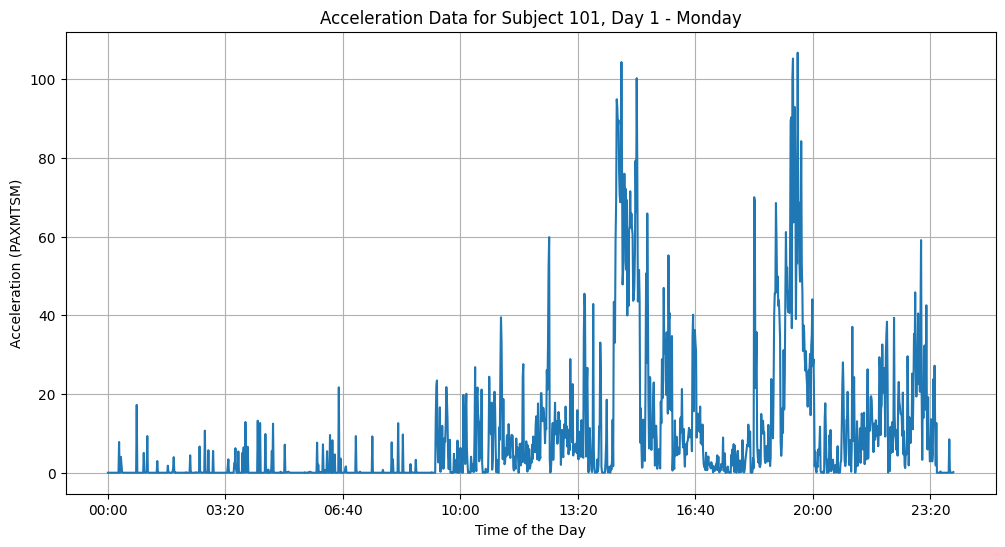

In [17]:
plot_subject_day_data(100, 0, matrix_3d) #Subject: [0, 7536], Day: [0, 6] (0=Monday, 6=Sunday)